In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from src.util import optimize_tools, load_tools, process_tools

In [2]:
'''Load data'''
p_raw, q_raw, t_raw, dt = load_tools.load_npy()
'''Process data'''
p_in, q_in, t_in             = process_tools.pre_process(p_raw, q_raw, t_raw, opt= "savgol")
p_out, q_out                 = process_tools.compute_output(p_in, q_in, t_in)
p_init, q_init, p_att, q_att = process_tools.extract_state(p_in, q_in)
p_in, q_in, p_out, q_out     = process_tools.rollout_list(p_in, q_in, p_out, q_out)

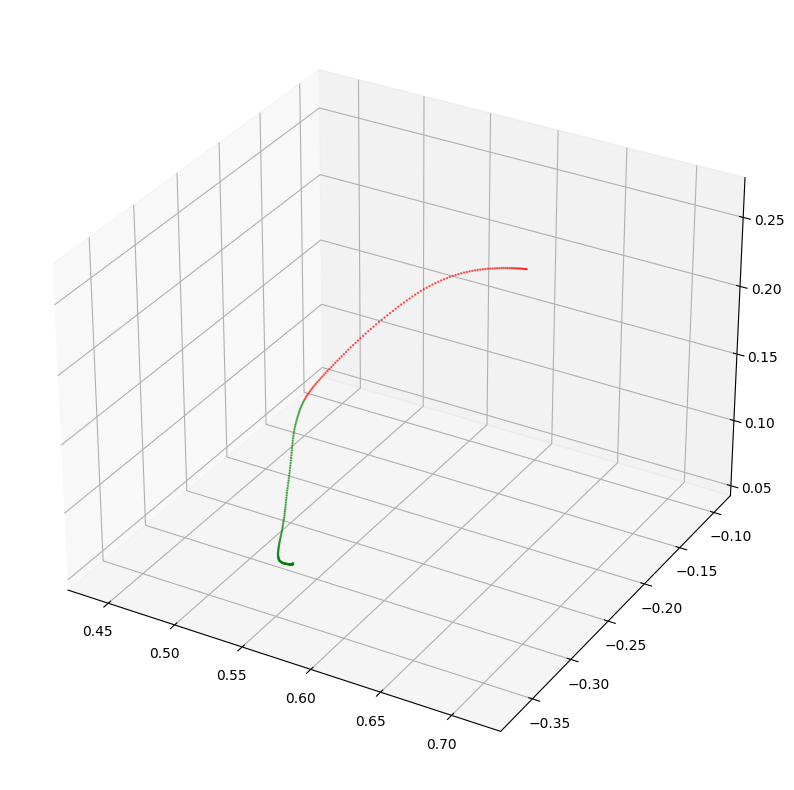

In [3]:
x = p_in
x_dot = p_out
x_att = p_att

x = p_in
x_dot = p_out

N1 = 100
sequence_arr = np.zeros((p_in.shape[0], ), dtype=int)
sequence_arr[N1: ] = 1

x_1 = x[sequence_arr==0, :]
x_dot_1 = x_dot[sequence_arr==0, :]


x_2 = x[sequence_arr==1, :]
x_dot_2 = x_dot[sequence_arr==1, :]

A_1 = [-1 * np.eye(3)]
A_2 = [-1 * np.eye(3)]

colors = ["r", "g", "b", "k", 'c', 'm', 'y', 'crimson', 'lime']
color_mapping = np.take(colors, sequence_arr)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], color=color_mapping[:], alpha= 0.6, s=0.5)
ax.axis('equal')
plt.show()

[[ 0.58812285 -0.35468278  0.08340594]]


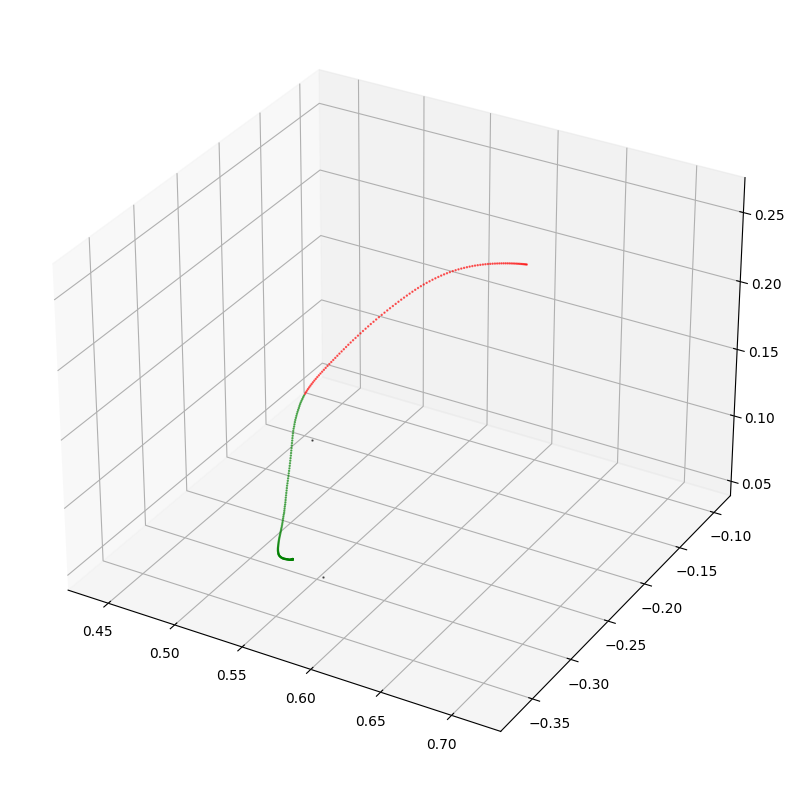

In [4]:
T = 100
x_att_list = []
for i in range(T):
    x_att_1 = optimize_tools.optimize_att(x_1, x_dot_1, A_1)
    A_1 = optimize_tools.optimize_A(x_1, x_dot_1, x_att_1)

    x_att_2 = optimize_tools.optimize_att(x_2, x_dot_2, A_2)
    A_2 = optimize_tools.optimize_A(x_2, x_dot_2, x_att_2)

print(x_att_2)

colors = ["r", "g", "b", "k", 'c', 'm', 'y', 'crimson', 'lime']
color_mapping = np.take(colors, sequence_arr)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], color=color_mapping[:], alpha= 0.6, s=0.5)
ax.scatter(x_att_1[:, 0], x_att_1[:, 1], x_att_1[:, 2], color='k', alpha= 0.6, s=0.5)
ax.scatter(x_att_2[:, 0], x_att_2[:, 1], x_att_2[:, 2], color='k', alpha= 0.6, s=0.5)

ax.axis('equal')
plt.show()

# Initialize Forward Variable 

In [17]:
n_S = 2 # number of S
M = p_in.shape[0]

alpha = np.zeros((M, n_S))

# Transition Probability

In [31]:
# Termination probability P(b=1|s, x)

thld = 0.04
# for i in range(x.shape[0]):
transitionMat = np.zeros((x.shape[0]-1, 2, 2)) # from column to row; A_ij = P(s_ip1 = si|s_i=s_j)

for i in np.arange(1, x.shape[0]):
# for i in [1]:
    x_i = x[i, :]

    #P(b_i=1|s_i=s1)
    p_b_1_s1 = 1 if np.linalg.norm(x_i - x_att_1) < thld else 0
    #P(b_i=0|s_i=s1)
    p_b_0_s1 = 1 - p_b_1_s1

    #P(b_i=1|s_i=s2)
    p_b_1_s2 = 1 if np.linalg.norm(x_i - x_att_2) < thld else 0
    #P(b_i=0|s_i=s2)
    p_b_0_s2 = 1 - p_b_1_s2


    #P(s_ip1=s2|s_i=s1, b_i=1)
    p_s_ip1_s2_s_i_s1_b_1 = 1
    #P(s_ip1=s2|s_i=s1, b_i=0)
    p_s_ip1_s2_s_i_s1_b_0 = 0

    #P(s_ip1=s1|s_i=s1, b_i=1) 
    p_s_ip1_s1_s_i_s1_b_1 = 0
    #P(s_ip1=s1|s_i=s1, b_i=0)
    p_s_ip1_s1_s_i_s1_b_0 = 1

    #P(s_ip1=s2|s_i=s2, b_i=1) 
    p_s_ip1_s2_s_i_s2_b_1 = 1 # special case because s2 is the last state, so it always remains regardless
    #P(s_ip1=s2|s_i=s2, b_i=0)
    p_s_ip1_s2_s_i_s2_b_0 = 1


    """Integrate over all possible b_i given s_i"""
    #P(s_ip1=s1|s_i=s1) = P(s_ip1=s1|s_i=s1, b_i=0) * P(b_i=0|s_i=s1) + P(s_ip1=s1|s_i=s1, b_i=1) * P(b_i=1|s_i=s1)

    P_s_ip1_s1_s_i_s1 =  p_s_ip1_s1_s_i_s1_b_0 * p_b_0_s1 + p_s_ip1_s1_s_i_s1_b_1 * p_b_1_s1

    #P(s_ip1=s2|s_i=s1) = 0 * x + 1 * y
    P_s_ip1_s2_s_i_s1 =  p_s_ip1_s2_s_i_s1_b_0 * p_b_0_s1 + p_s_ip1_s2_s_i_s1_b_1 * p_b_1_s1
    # print(np.linalg.norm(x_i - x_att_2))


    #P(s_ip1=s1|s_i=s2)
    P_s_ip1_s1_s_i_s2 = 0

    #P(s_ip1=s2|s_i=s2) = P(s_ip1=s2|s_i=s2, b_i=0) * P(b_i=0|s_i=s2) + P(s_ip1=s2|s_i=s2, b_i=1) * P(b_i=1|s_i=s2)
    P_s_ip1_s2_s_i_s2 = p_s_ip1_s2_s_i_s2_b_0 * p_b_0_s2 + p_s_ip1_s2_s_i_s2_b_1 * p_b_1_s2


    transitionMat[i-1, 0, 0] = P_s_ip1_s1_s_i_s1
    transitionMat[i-1, 0, 1] = P_s_ip1_s1_s_i_s2
    transitionMat[i-1, 1, 0] = P_s_ip1_s2_s_i_s1
    transitionMat[i-1, 1, 1] = P_s_ip1_s2_s_i_s2



# Emission Probability

In [32]:
mu_1 = np.mean(x_1, axis=0)
Sigma_1 = np.cov(x_1.T)

mu_2 =  np.mean(x_2, axis=0)
Sigma_2 = np.cov(x_2.T)

cov_em_1 = np.cov((x_dot_1.T - (A_1[0] @ (x_1-x_att_1).T)))

cov_em_2 = np.cov((x_dot_2.T - (A_2[0] @ (x_2-x_att_2).T)))

emissionMat = np.zeros((x.shape[0], 2)) 
# for i in [0, 1]:
for i in range(x.shape[0]):
    x_i = x[i, :]
    x_dot_i = x_dot[i, :]

    #P(x_ip1|s_ip1=s1) 
    P_x_ip1_s_ips_s1 = multivariate_normal.pdf(x_i, mean=mu_1, cov=Sigma_1)

    #P(x_ip1|s_ip1=s2) 
    P_x_ip1_s_ips_s2 = multivariate_normal.pdf(x_i, mean=mu_2, cov=Sigma_2)

    #P(x_dot_ip1|x_ip1, s_ip1=s1)
    mu_em_1 = A_1[0] @ (x_i.reshape(1, -1) - x_att_1).T
    P_x_dot_ip1_x_ip1_s_ip1_s1 =  multivariate_normal.pdf(x_dot_i, mean=mu_em_1[:, 0], cov=cov_em_1)

    #P(x_dot_ip1|x_ip1, s_ip1=s2)
    mu_em_2 = A_2[0] @ (x_i.reshape(1, -1) - x_att_2).T
    P_x_dot_ip1_x_ip1_s_ip1_s2 =  multivariate_normal.pdf(x_dot_i, mean=mu_em_2[:, 0], cov=cov_em_2)


    #P(x_ip1, x_dot_ip1|s_ip1=s1) = P(x_dot_ip1|x_ip1, s_ip1=s1) * P(x_ip1|s_ip1=s1) 
    P_x_ip1_x_dot_ip1_s_ip1_s1 = P_x_dot_ip1_x_ip1_s_ip1_s1 * P_x_ip1_s_ips_s1

    #P(x_ip1, x_dot_ip1|s_ip1=s2) = P(x_dot_ip1|x_ip1, s_ip1=s2) * P(x_ip1|s_ip1=s2) 
    P_x_ip1_x_dot_ip1_s_ip1_s2 = P_x_dot_ip1_x_ip1_s_ip1_s2 * P_x_ip1_s_ips_s2

    emissionMat[i, 0] = P_x_ip1_x_dot_ip1_s_ip1_s1
    emissionMat[i, 1] = P_x_ip1_x_dot_ip1_s_ip1_s2

print(emissionMat)

[[2.64252958e+006 0.00000000e+000]
 [7.23738481e+006 0.00000000e+000]
 [2.44852893e+007 0.00000000e+000]
 [5.49976382e+007 0.00000000e+000]
 [1.59386766e+008 0.00000000e+000]
 [3.47542165e+008 0.00000000e+000]
 [7.39827618e+008 0.00000000e+000]
 [1.45367195e+009 0.00000000e+000]
 [2.21920934e+009 0.00000000e+000]
 [4.02753340e+009 0.00000000e+000]
 [6.22154009e+009 0.00000000e+000]
 [8.02499477e+009 0.00000000e+000]
 [1.13253351e+010 0.00000000e+000]
 [1.40159710e+010 0.00000000e+000]
 [1.66808818e+010 0.00000000e+000]
 [1.79913729e+010 0.00000000e+000]
 [1.93240300e+010 0.00000000e+000]
 [1.96307768e+010 0.00000000e+000]
 [1.99145223e+010 0.00000000e+000]
 [1.54949371e+010 0.00000000e+000]
 [1.72443101e+010 0.00000000e+000]
 [1.10349399e+010 0.00000000e+000]
 [1.16138180e+010 0.00000000e+000]
 [1.16077907e+010 0.00000000e+000]
 [1.09725803e+010 0.00000000e+000]
 [6.57660399e+009 0.00000000e+000]
 [4.17923945e+009 0.00000000e+000]
 [6.78906212e+009 0.00000000e+000]
 [6.42664467e+009 0.

# Propagate Forward Variable

In [34]:
# alpha_1(s_1=s1) = P(x_0, x_dot_0, x_1, x_dot_1, s_1=s1) 
#                 = P(x_1, x_dot_1|s_1=s1) * (P(x_0, x_dot_0, s_0=s1)*P(s_1=s1|s_0=s1)+P(x_0, x_dot_0, s_0=s2)*P(s_1=s1|s_0=s2))


# alpha_0(s_0=s1) = P(x_0, x_dot_0, s_0=s1) = P(x_0, x_dot_0|s_0=s1) * P(s_0=s1)
alpha[0, 0] = emissionMat[0, 0] * 1/2

# alpha_0(s_0=s2) = P(x_0, x_dot_0, s_0=s2) = P(x_0, x_dot_0|s_0=s2) * P(s_0=s2)
alpha[0, 1] = emissionMat[0, 1] * 1/2

# normalize
alpha[0, :] = alpha[0, :]/np.sum(alpha[0, :])


for i in np.arange(1, alpha.shape[0]):
# for i in [1]:
    # alpha[1, 0] = P_x_ip1_x_dot_ip1_s_ip1_s1 * (alpha[0,0] * P_s_ip1_s1_s_i_s1 + alpha[0,1] * P_s_ip1_s1_s_i_s2)
    alpha[i, 0] = emissionMat[i, 0] * (alpha[i-1,0] * transitionMat[i-1, 0, 0] + alpha[i-1,1] * transitionMat[i-1, 0, 1])

    # alpha_1(s_1=s2) = P(x_0, x_dot_0, x_1, x_dot_1, s_1=s2) 
    #                 = P(x_1, x_dot_1|s_1=s1) * (P(x_0, x_dot_0, s_0=s1)*P(s_1=s2|s_0=s1)+P(x_0, x_dot_0, s_0=s2)*P(s_1=s2|s_0=s2))
    alpha[i, 1] = emissionMat[i, 1] * (alpha[i-1,0] * transitionMat[i-1, 1, 0] + alpha[i-1,1] * transitionMat[i-1, 1, 1])
   

    if np.sum(alpha[i, :]) ==0:
        a = 1
        pass

    alpha[i, :] = alpha[i, :]/np.sum(alpha[i, :])

print(alpha)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 